<a href="https://colab.research.google.com/github/sahithijarugula/Recognize_Cloud_Coverage/blob/main/Copy_of_Final_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **FIRE199 FINAL REPORT**
##Recognizing & Determining Cloud Amount Coverage

###Sahithi Jarugula & Foang Chou

####Last Updated: July 21, 2022

#**Introduction**

## Topic
The major topic for our project is to be able to efficiently and accurately detect cloud amount coverage in citizen data through the use of a classification system. The system categorizes cloud amount into 6 categories: none, mostly clear, isolated, scattered, broken and overcast. In order to achieve an accurate system that distinguishes cloud coverage from citizen data we aim to use thresholding and morphological snake methods. Thresholding will be done in order to distinguish clouds from the background. Morphological snakes will be done in order to detect the contours of the clouds. Through these two techniques, we expect to contribute to prior research and improve the accuracy of cloud coverage detection. By utilizing these methods, we are interested to see if it becomes a more accurate and effective method in determining cloud coverage.
## Importance of Our Research
Cloud coverage is an important element in understanding the earth’s atmosphere and predicting the weather. For example, clouds can reduce and block the penetration of long-wave radiation and monitoring cloud coverage can improve scientists knowledge on radiation patterns. Through this project, we aim to contribute to further research on such topics. By improving the efficiency and accuracy of a cloud coverage classification system, we can largely speed up the process of future research.


# **Dependencies**



In [ ]:
#Image Processing
import skimage.filters

#Image Display & Color Conversion
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image

#Arrays & Matrices
import numpy as np

#Dataframes
import pandas as pd

#Image plotting
import matplotlib.pyplot as plt

#Confusion Matrix Creation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#Image Importing
from google.colab import files
from google.colab import drive

#Allowing notebook access to Google Dive
drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


# **Data**
We compiled 120 Citizen GLOBE images to test our classification methods on. That data is shown in the dataframe below. The classification results of the thresholding and morphological snakes methods are linked below the data.

In [ ]:
sheet_url = "https://docs.google.com/spreadsheets/d/1BmXDMmFj98ql52MJBORxWPPOWRkO8rdV5wRI-tfUGw4/edit#gid=0"
url_1 = sheet_url.replace('/edit#gid=', '/export?format=csv&gid=')
sdf = pd.read_csv(url_1, error_bad_lines=False)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


##Thresholding Results
https://colab.research.google.com/drive/17a5VyoVFzCYs98UuYUsUoHVWZ8rmNeQ3?usp=sharing

##Morphological Snakes Results
https://colab.research.google.com/drive/17Ov-g9sCqfTgwigTJi271hF9e7XKWIw5?usp=sharing

#**Methods**

##**Thresholding Methods**

The first thresholding method we experimented with uses a given image's saturation. Most images are BGR images, meaning each pixel has a color, which is created by combining different amounts of blue, green and red. This method converts such images into HSV images, which stands for hue, saturation and value. We do this to maximize the saturation of the image, which we in turn hoped would emphasize the difference between the cloud and sky pixels in the image. Then, we use otsu thresholding to create a threshold of the saturated image. We hope that the otsu thresholding can find a more effective threshold value due to the heightened saturation of the image. Before returning the threshold image, the method checks the threshold value. We noticed a pattern that if a threshold value is high enough the image can be considered overcast and if it is low enough it can be considered none or mostly clear. Since these three categories have either a lot of cloud pixels or a lot of sky pixels, there are no two clear peaks between the amount of blue and the amount of white in the image. As a result the threshold image of these images alone is not very accurate. So, we included these conditional statements about the threshold values in hopes to automatically classify such images as overcast, none or mostly clear.

In [ ]:
def saturation_thresholding(image, thresholds):
  #Convert to hsv
  hsv_image = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2HSV)
  #Inverts hsv
  inverted_hsv = cv2.bitwise_not(hsv_image)
  #Hsv to gray scale
  gray = cv2.cvtColor(inverted_hsv, cv2.COLOR_BGR2GRAY)
  blurred = cv2.GaussianBlur(gray, (5,5), 0)
  #Thresholding
  (T, thresh) = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
  thresholds = np.append(thresholds, T)
  if(T < 80):
    thresh = None
  elif(T < 90):
    thresh = convert_thresh(image, 0)
  elif(T > 178):
    thresh = convert_thresh(image, 255)
  return thresh, thresholds

The next thresholding method is very similar to the saturation method discussed earlier. After a BGR image is converted to an HSV image and its saturation is maximized, instead of directly thresholding that image, we used the createCLAHE method. CLAHE stands for Contrast Limited Adaptive Histogram Equalization. Since, threshold values are found using histograms, CLAHE will help make that value more accurate. This method also checks the threshold values before returning the final image to see if there are any images that can be automatically classified as overcast, none or mostly clear.

In [ ]:
def clahe_thresholding(image, thresholds):
  #Saturates image by getting its hsv version
  hsv_image = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2HSV)
  #Inverts hsv
  inverted_hsv = cv2.bitwise_not(hsv_image)
  #Hsv to gray scale
  gray = cv2.cvtColor(inverted_hsv, cv2.COLOR_BGR2GRAY)
  blurred = cv2.GaussianBlur(gray, (5,5), 0)
  #CLAHE - good for overcast images
  clahe = cv2.createCLAHE(clipLimit = 5)
  final_img = clahe.apply(blurred) + 30
  #Thresholding
  (T, thresh) = cv2.threshold(final_img, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
  thresholds = np.append(thresholds, T)
  if(T < 80):
    thresh = None
  elif(T < 90):
    thresh = convert_thresh(image, 0)
  elif(T > 176):
    thresh = convert_thresh(image, 255)
  return thresh, thresholds

The main objective in any thresholding method is to separate cloud pixels from sky pixels. The ideology behind the blue channel thresholding method we experimented with is that pixels of the sky will have higher and more distinct blue channel values. So, this method extracts the blue channel of a given image of the sky and then converts that blue channel into a thresholded image using adaptive thresholding in hope that the cloud pixels are more distinct now that the blue channel has been extracted.

In [ ]:
def blue_channel(image):
  #Extracts blue channel of image
  blue_channel = image[:, :, 2]
  blue_image = np.zeros(image.shape)
  blue_image[:, :, 0] = blue_channel
  #Saturates the blue channel by getting its hsv version
  hsv_image = cv2.cvtColor(blue_image.astype(np.uint8), cv2.COLOR_BGR2HSV)
  invert_hsv = cv2.bitwise_not(hsv_image)
  #Converts to gray scale
  gray = cv2.cvtColor(invert_hsv, cv2.COLOR_BGR2GRAY)
  blurred = cv2.GaussianBlur(gray, (5,5), 0)
  #Finds threshold using adaptive thresholding
  adaptive = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 101, 5)

  return adaptive

While using the above methods we realized that some of the methods work better for certain cloud coverage categories than others. For example, the Blue Channel method works better for none and mostly clear images, whereas the CLAHE method works best for overcast images. Saturation thresholding is best for the rest of the cloud coverage categories. This method looks at the threshold values returned from the Saturation and CLAHE methods in an attempt to distinguish the none, mostly clear, and overcast images from the rest of the images. If the CLAHE method returns a threshold higher than 176, then the image is usually an overcast image and the CLAHE method's classification is used. If the Saturation method's threshold is below 95 then the image is probably a none or mostly clear image, so the blue channel method will be run. If neither of these conditions applies to the two threshold values then the Saturation method will run. However, this technique does not work for all none, mostly clear and overcast images because sometimes there are images where the CLAHE threshold is above 176 and the Saturation threshold is below 95. In these cases, the method cannot tell if the image is overcast or if it is none or mostly clear. When this happens we just automatically make the method think the image is overcast in order to get some sort of result for such images.

In [ ]:
def hybrid_thresholding(image, threshold1, threshold2, saturation_label, clahe_label, blue_label):
  if threshold2 > 176:
    return clahe_label
  elif threshold1 < 95:
    return blue_label
  else:
    return saturation_label

The method below is a helper method. It is used in the other methods for none and overcast images. For example, if the CLAHE method calculates a threshold value higher than 176, then it will assume the image is overcast. If it assumes this then the method will call this convert_thresh method and turn the entire image to white. Likewise, if any of the methods determine that the image is in the none category based on the threshold values they calculate, they will turn the entire image to black. We used this method so that such images could still be run through the classify method (shown later), which classifies the cloud coverage for all thresholded images.

In [ ]:
def convert_thresh(image, value):
  thresh = Image.fromarray(image)
  pixel_map = thresh.load()
  width, height = thresh.size
  for i in range(width):
    for j in range(height):
      pixel_map[i, j] = (value, value, value)
  thresh = cv2.cvtColor(np.array(thresh), cv2.COLOR_RGB2BGR)
  thresh = cv2.cvtColor(np.array(thresh), cv2.COLOR_BGR2GRAY)
  return thresh

The classify method below determines the cloud coverage for thresholded images. It does this by counting the amount of pixels in the thresholded images that are white, dividing that number by the total amount of pixels in the image, and then multiplying that number by 100. This is the percentage of cloud in the thresholded image. Then the method classifies that percentage using official intervals for cloud coverage shown below.

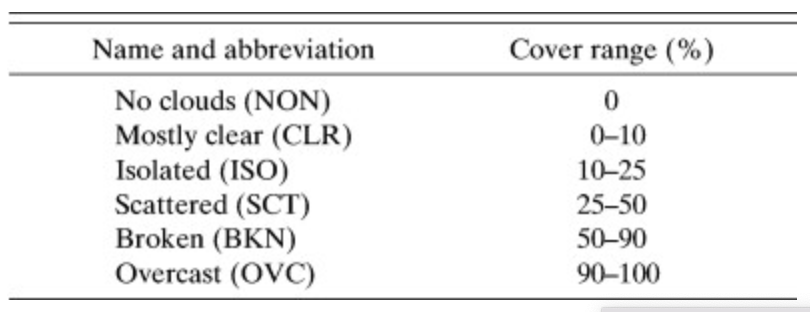

In [ ]:
def classify(thresh):
  #Calculate percentage of cloud pixels in image of sky
  if thresh is None:
    percentage = 5
  else:
    cloud_pixels = np.sum(thresh == 255)
    width, height = thresh.shape
    percentage = cloud_pixels/(width*height) * 100
  #Return cloud coverage category
  if percentage == 0:
    return "None"
  elif percentage < 10:
    return "Mostly Clear"
  elif percentage < 25:
    return "Isolated"
  elif percentage < 50:
    return "Scattered"
  elif percentage < 90:
    return "Broken"
  else:
    return "Overcast"

Confusion Matrix Results of the above thresholding methods can be found towards the end of the colab notebook below:
https://colab.research.google.com/drive/17a5VyoVFzCYs98UuYUsUoHVWZ8rmNeQ3?usp=sharing

##**Morphological Snake Methods**

The morphological snake method utilizes image contours in order to separate background and foreground. In this method, we are separating the cloud contours from the sky. A Gaussian filter is applied to the image in order to reduce noise. Furthermore, the image undergoes the Otsu thresholding to determine a threshold that separates background and foreground. With these two image processing methods, we are able to determine cloud coverage.

In [ ]:
#Methods
def morphological_snakes(image):
  #Converting image to gray
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  #Image smoothing with Gaussian Filter
  gauss = skimage.filters.gaussian(gray, sigma=40)
  cv2_imshow(gauss)
  #Automatic Threshold with the Otsu method
  th = skimage.filters.threshold_otsu(gauss)
  return gauss, th

def classify_morph(gauss, th):
  #Coverage detection calculation
  count = np.count_nonzero(gauss > th)
  size = gauss.size
  coverage = count / size * 100
  #Return cloud category
  if coverage == 0:
    return "None"
  elif coverage < 10:
    return "Mostly Clear"
  elif coverage < 25:
    return "Isolated"
  elif coverage < 50:
    return "Scattered"
  elif coverage < 90:
    return "Broken"
  else:
    return "Overcast"


Confusion Matrix Results of the above morphological snake method can be found towards teh end of the colab notebook below:
https://colab.research.google.com/drive/17Ov-g9sCqfTgwigTJi271hF9e7XKWIw5?usp=sharing

##**Confusion Matrix of Combined Methods**
Below is the data used to create two confusion matrices that show the performance of all the methods. The 'Best' column checks each image and sees if any of the images classified it correctly and if any of them did it uses that value. If none of them classified it correctly it takes the closest classification. The 'App' column uses the same values that the Anvil web app would use when given a classification as an input from the user (this is described more in the Anvil Web App section).

In [ ]:
#Dataframe of the actual and predicted values of the combined methods
data = {
  "True Values": sdf['Category'].to_numpy(), #Actual values
  "Best": sdf['Best'].to_numpy(),            #Predicted values
  "App": sdf['App'].to_numpy(),              #Predicted values
}

#Creates Data Frame from data above
df = pd.DataFrame(data)

#Converts all values to numbers to be used in confusion matrix method later
combined_values = df.replace({'None' : 0, 'Mostly Clear' : 1, 'Isolated' : 2, 'Scattered' : 3, 'Broken' : 4, 'Overcast' : 5})

NameError: ignored

(Data from the first combined confusion matrix is further discussed and shown in a more readable table in the conclusion.)

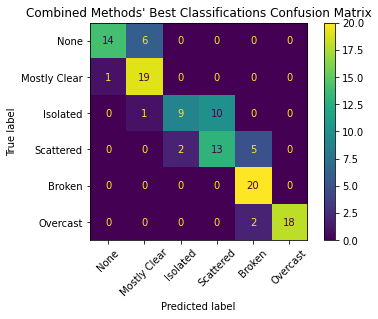

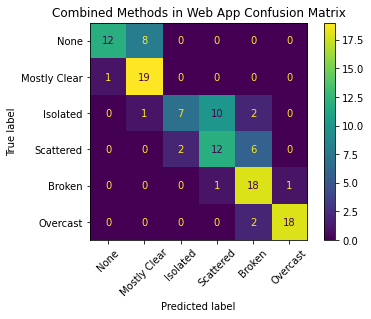

In [ ]:
#Confusion matrix of all methods' best classifications (77.5% success rate)
matrix = confusion_matrix(combined_values['True Values'], combined_values['Best'])
cs_matrix = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=['None', 'Mostly Clear', 'Isolated', 'Scattered', 'Broken', 'Overcast'])
cs_matrix.plot()
cs_matrix.ax_.set_title("Combined Methods' Best Classifications Confusion Matrix")
plt.xticks(rotation = 45)
plt.show()

#Confusion matrix of methods used in Anvil Web App (71.67% success rate)
matrix = confusion_matrix(combined_values['True Values'], combined_values['App'])
cs_matrix = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=['None', 'Mostly Clear', 'Isolated', 'Scattered', 'Broken', 'Overcast'])
cs_matrix.plot()
cs_matrix.ax_.set_title("Combined Methods in Web App Confusion Matrix")
plt.xticks(rotation = 45)
plt.show()

# **Anvil Web App**
We used the program Anvil to connect our colab code to a user interface. Below is code that is used to connect this colab notebook to Anvil.

In [ ]:
!pip install anvil-uplink
import anvil.server
anvil.server.connect("H7VWS4L4R4SX3NTWFYSZKNEA-PNWFJQSP6UOTQNBB")


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 6.4 MB/s 
     |████████████████████████████████| 51 kB 238 kB/s 
  Created wheel for ws4py: filename=ws4py-0.5.1-py3-none-any.whl size=45229 sha256=ab6d3bf6a3518a4d2cf5bbf7481aa42981376b25213a066bcce9bf9686a40b38
  Stored in directory: /root/.cache/pip/wheels/29/ea/7d/3410aa0aa0e4402ead9a7a97ab2214804887e0f5c2b76f0c96
Successfully built ws4py


Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default environment" as SERVER


The main method below is used to classify an uploaded image in our [web app](https://PNWFJQSP6UOTQNBB.anvil.app/7XQKPRFFADXRZ3QSBGC5WRAZ). The web app uses the if statement to determine what to do if the user inputs their guess as to what the cloud coverage of their uploaded image is (the following process is the combined methods process that is evaluated in the second combined confusion matrix). If the user inputs none or mostly clear the blue channel thresholding method will run. If they input scattered the morphological snakes method will run. If they input overcast the CLAHE method will run. If they input anything else, the saturation method will run.If they don't input anything at all, all of the methods will run. The app then displays the results it gets from the colab code.

In [ ]:
@anvil.server.callable
def main(image, coverage = None):
  arr = np.fromstring(image.get_bytes(), np.uint8)
  image = cv2.imdecode(arr, cv2.IMREAD_COLOR)
  if coverage is None:
    threshold1 = np.array([])
    threshold2 = np.array([])
    saturation_thresh, threshold1 = saturation_thresholding(image, threshold1)
    clahe_thresh, threshold2 = clahe_thresholding(image, threshold2)
    saturation_label = classify(saturation_thresh)
    clahe_label = classify(clahe_thresh)
    blue_thresh = blue_channel(image)
    blue_label = classify(blue_thresh)
    hybrid_label = hybrid_thresholding(image, threshold1[0], threshold2[0], saturation_label, clahe_label, blue_label)
    gauss, th = morphological_snakes(image)
    morph_label = classify_morph(gauss, th)
    labels = [saturation_label, clahe_label, blue_label, hybrid_label, morph_label]
    return labels
  else:
    if coverage is "none" or coverage is "mostly clear":
      img = blue_channel(image)
      return classify(img)
    elif coverage is "scattered":
      gauss, th = morphological_snakes(image)
      return classify_morph(gauss, th)
    elif coverage is "overcast":
      clahe_thresh, threshold2 = clahe_thresholding(image, None)
      return classify(clahe_thresh)
    else:
      saturation_thresh, threshold1 = saturation_thresholding(image, None)
      return classify(saturation_thresh)

# **Conclusion**

Overall, we were able to complete our major goal of creating a classification system to identify cloud coverage in citizen science data images. Our system is able to run and utilizes Saturation Thresholding, CLAHE Thresholding, Blue Channel Thresholding, and Morphological Snakes. Among these four methods, we are able to utilize the method for each cloud coverage category that will output the most accurate prediction of the cloud coverage.




An issue to still be resolved is improving the overall accuracy rate of our methods. Below is a table that shows how many of the citizen science data images were correctly classified by at least one of our methods. The classifications that we seem to have the most trouble with is 'Isolated' and 'Scattered,' as none of our methods were able to correctly classify seventeen images from the two categories. In fact, most of the time they would misclassify an 'Isolated' image as 'Scattered' and vice versa.


|  Category  |Accuracy   |Percentage |
|------------|:----------|:----------|
|None        |14/20      |70%        |
|Mostly Clear|19/20      |95%        |
|Isolated    |9/20       |45%        |
|Scattered   |13/20      |65%        |
|Broken      |19/20      |95%        |
|Overcast    |18/20      |90%        |



While our classification system was not completely accurate, this can be improved in the future with adaptations to our current methods. Furthermore, we can better verify the accuracy rate of the system if a cleaned dataset is used. The current dataset used for this research was self-classified by the submitters of the images. This means that there could be inaccurate classifications that may have lowered the accuracy rate of our classification system.


# **Sources**
https://ieeexplore.ieee.org/abstract/document/4505540
https://www.cse.msu.edu/~rossarun/pubs/RossIrisGAC_BSYM2006.pdf
http://demo.ipol.im/demo/abmh_real_time_morphological_snakes_algorithm/
https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/2021EA002058